In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
from scipy.signal import find_peaks
import pickle 
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
import numpy.ma as ma
from astropy.stats import sigma_clip
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import mpl_toolkits.axes_grid1.axes_grid as axes_grid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from mpl_toolkits.axes_grid.colorbar import colorbar
from matplotlib.patches import Ellipse
import math
from matplotlib import cm
from astropy.wcs import WCS
import scipy
import scipy.ndimage as ndi
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import pkg_resources
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from __future__ import print_function
import pyspeckit
import pylab as pl

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

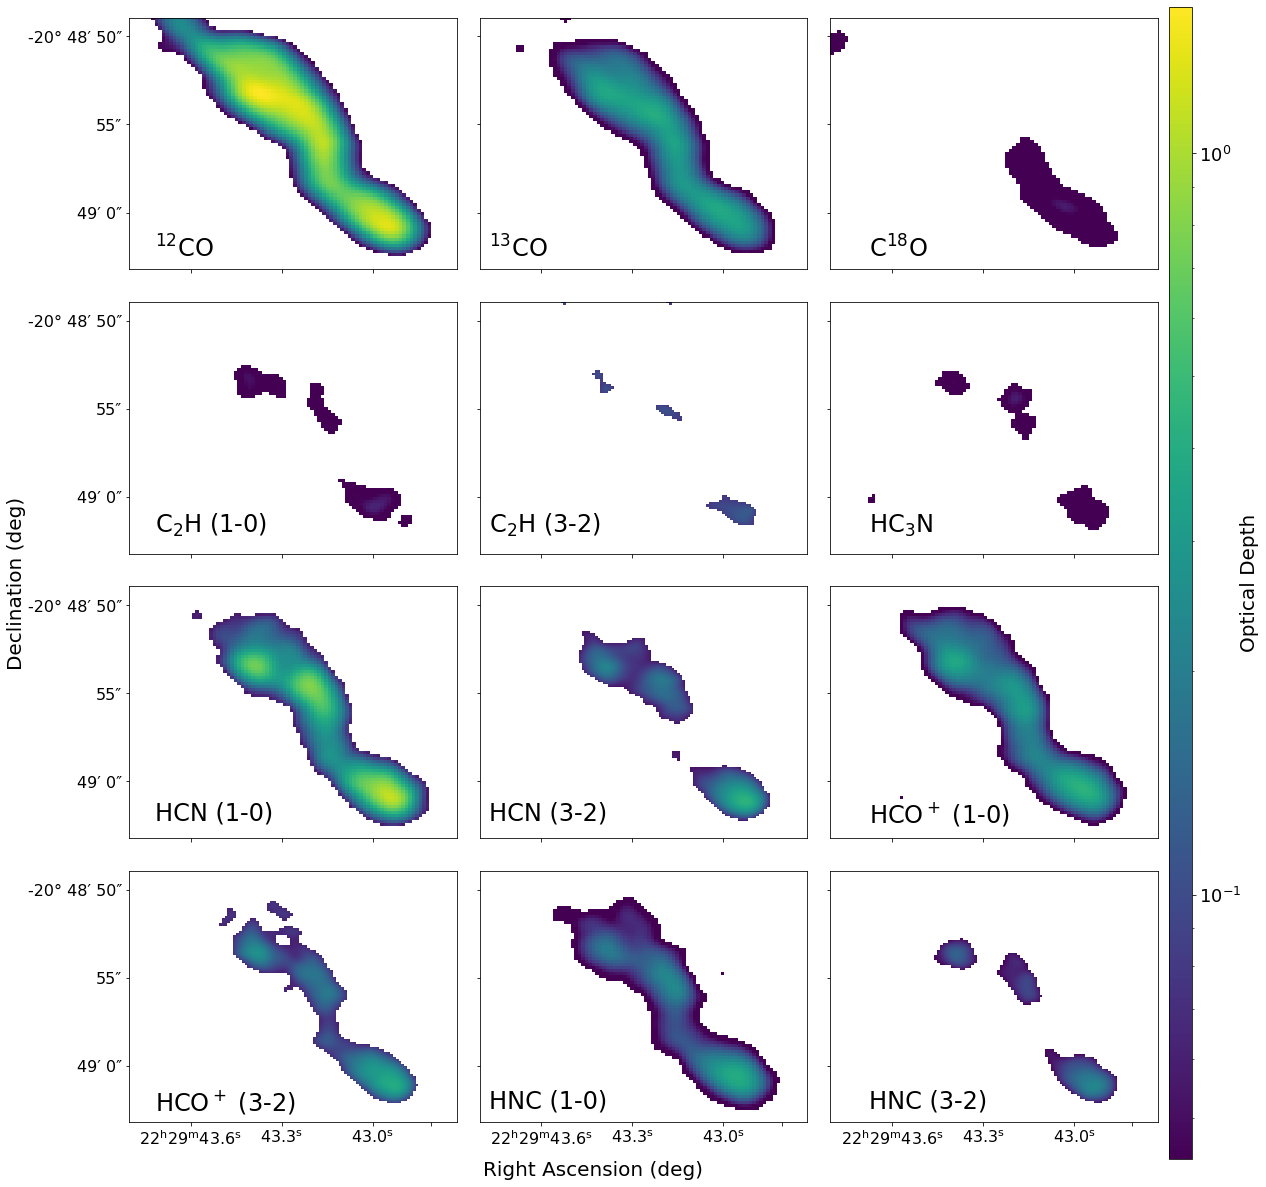

In [74]:
fig = plt.figure(figsize = [16, 16])
source_array = ['12CO', '13CO', 'C18O', 'CCH', 'CCH_32', 'HC3N', 'HCN', 'HCN_32', 'HCOp', 'HCOp_32', 'HNC', 'HNC_32']

def opt_depth_map(globule ='GlobB', source = '12CO'):
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    data1 = data[0,:,:,:]
    h = 6.62608e-34
    k = 1.38065e-23

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)

    freq_start_ghz = header["CRVAL3"]/1e9
    freq_inc_ghz = header["CDELT3"]/1e9
    frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
    frequency_ghz = np.array(frequency_ghz, dtype = float)

    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    #print(vel_inc)

    if globule == 'GlobB':
        x1 = round(header["CRPIX1"]-(ra_start-337.43248)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.8175)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(dec_start+20.81354)/dec_inc)-2
    elif globule == 'GlobC':
        x1 = round(header["CRPIX1"]-(ra_start-337.40975)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.40565)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.803)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(dec_start+20.797)/dec_inc)-2

    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    hnu_k = h*frequency[0]/k

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)

    if source == '12CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.12
    elif source == '13CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.1
    elif source == 'C18O':
        if globule == 'GlobB':
            d = 0.28
        else:
            d = 0.15
    elif source == 'CCH':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.15
    elif source == 'CCH_32':
        if globule == 'GlobB':
            d = 0.15
        else:
            d = 0.08
    elif source == 'HC3N':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.25
    elif source == 'HCN':
        if globule == 'GlobB':
            d = 0.06
        else:
            d = 0.08
    elif source == 'HCN_32':
        if globule == 'GlobB':
            d = 0.065
        else:
            d = 0.04
    elif source == 'HCOp':
        if globule == 'GlobB':
            d = 0.08
        else:
            d = 0.1
    elif source == 'HCOp_32':
        if globule == 'GlobB':
            d = 0.1
        else:
            d = 0.08
    elif source == 'HNC':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.08
    elif source == 'HNC_32':
        if globule == 'GlobB':
            d = 0.2
        else:
            d = 0.12

    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d*max_val:
            array.append(a[i])
    extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

    moment0 = np.sum(data3[array, :, :], axis = 0)*abs(vel_inc)
    sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    mom0 = np.ma.array(moment0, mask = newmask)
    bmaj = header['BMAJ']#major beam width
    bmin = header['BMIN']#minor beam width
    I = np.nanmax(mom0)    
    t_mb = 1.222e3*mom0*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    #Tex = 24.96 #Globule C
    Tex = 23.94604986 #Globule B
    den = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb/hnu_k
    almost = 1-den
    opt_depth_map = -np.log(almost) 
    return opt_depth_map   
 
plt.subplot(431)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = '12CO'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
           norm=mpl.colors.LogNorm())
ax1 = fig.add_subplot(4, 3, 1)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax1.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax1.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax1.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
ax1.set_xticklabels([' ', ' ', ' '], fontsize = 16)

cbaxes1 = fig.add_axes([1.0, 0.0, 0.02, 1], zorder = 4) 
cbar1 = plt.colorbar(cax=cbaxes1, orientation='vertical')

for t in cbar1.ax.get_yticklabels():
    t.set_fontsize(18)

plt.subplot(432)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = '13CO'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto', 
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax2 = fig.add_subplot(4, 3, 2)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax2.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax2.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax2.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
ax2.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(433)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'C18O'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax3 = fig.add_subplot(4, 3, 3)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax3.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax3.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax3.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
ax3.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(434)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'CCH'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax4 = fig.add_subplot(4, 3, 4)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax4.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax4.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax4.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
ax4.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(435)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'CCH_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax5 = fig.add_subplot(4, 3, 5)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax5.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax5.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax5.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
ax5.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(436)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'HC3N'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax6 = fig.add_subplot(4, 3, 6)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax6.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax6.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax6.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
ax6.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(437)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'HCN'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax7 = fig.add_subplot(4, 3, 7)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax7.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax7.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax7.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
ax7.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(438)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'HCN_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax8 = fig.add_subplot(4, 3, 8)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax8.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax8.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax8.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
ax8.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(439)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'HCOp'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax9 = fig.add_subplot(4, 3, 9)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax9.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax9.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax9.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
ax9.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(4,3,10)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'HCOp_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax10 = fig.add_subplot(4, 3, 10)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax10.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax10.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax10.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3], ra[ra_val4]])
ax10.set_xticklabels(['$\mathrm{22^{h}29^{m}43.6^{s}}$', '$\mathrm{43.3^{s}}$', '$\mathrm{43.0^{s}}$'], fontsize = 16)

plt.subplot(4,3,11)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'HNC'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax11 = fig.add_subplot(4, 3, 11)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax11.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax11.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax11.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3], ra[ra_val4]])
ax11.set_xticklabels(['$\mathrm{22^{h}29^{m}43.6^{s}}$', '$\mathrm{43.3^{s}}$', '$\mathrm{43.0^{s}}$'], fontsize = 16)

plt.subplot(4,3,12)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map(globule = 'GlobB', source = 'HNC_32'), origin='lower', cmap=cm1, extent = extent, aspect = 'auto',
          norm=colors.LogNorm(vmin=np.nanmin(opt_depth_map(globule = 'GlobB', source = '12CO')), 
                              vmax=np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax12 = fig.add_subplot(4, 3, 12)

dec_val4 = np.abs(dec + 20.8138889).argmin()
dec_val3 = np.abs(dec + 20.8152778).argmin()
dec_val2 = np.abs(dec + 20.8166667).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax12.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
ax12.set_yticklabels([' ',' ',' ', ' '], fontsize = 16)

ra_val1 = np.abs(ra - 337.4316667).argmin()
ra_val2 = np.abs(ra - 337.4304167).argmin()
ra_val3 = np.abs(ra - 337.4291667).argmin()
#ra_val4 = np.abs(ra - 337.4283333).argmin()
ax12.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3], ra[ra_val4]])
ax12.set_xticklabels(['$\mathrm{22^{h}29^{m}43.6^{s}}$', '$\mathrm{43.3^{s}}$', '$\mathrm{43.0^{s}}$'], fontsize = 16)

fig.text(0.5, -0.01, 'Right Ascension (deg)', fontsize=20, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal')
fig.text(0.0, 0.5, 'Declination (deg)', fontsize=20, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
fig.text(1.07, 0.5, 'Optical Depth', fontsize=20, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')

fig.text(0.12, 0.79, '$^{12}$CO', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.41, 0.79, '$^{13}$CO', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.74, 0.79, 'C$^{18}$O', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.12, 0.55, 'C$_2$H (1-0)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.41, 0.55, 'C$_2$H (3-2)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.74, 0.55, 'HC$_3$N', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.12, 0.3, 'HCN (1-0)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.41, 0.3, 'HCN (3-2)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.74, 0.3, 'HCO$^+$ (1-0)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.12, 0.05, 'HCO$^+$ (3-2)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.41, 0.05, 'HNC (1-0)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
fig.text(0.74, 0.05, 'HNC (3-2)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')


plt.tight_layout()
plt.savefig(globule + '_' + 'Optical_Depth_Final.png', bbox_inches='tight')

In [114]:
def ra(source = 'HCN'):
    path = 'GlobC_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)
    return ra

def dec(source = 'HCN'):
    path = 'GlobC_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    #print(data.shape)
    header = cube[0].header
    
    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    return dec

np.abs(dec(source = 'CCH') +20.7972222).argmin()
#print(dec(source = 'CCH')[348])

#np.abs(dec(source = 'CCH') + 20.7972222).argmin()

348

In [110]:
#source = 'HNC_32'
#path = 'GlobC_' + source + '.image.pbcor.fits'
#cube = fits.open(path)
#data = cube[0].data
#print(data.shape)
#header = cube[0].header
#ra_start = header["CRVAL1"]
#ra_inc = header["CDELT1"]

#channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

#ra = ra_start + (ra_inc * channels)
#ra = np.array(ra, dtype = float)

#dec_start = header["CRVAL2"]
#dec_inc = header["CDELT2"]

#channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

#dec = dec_start + (dec_inc * channels1)
#dec = np.array(dec, dtype = float)

#x1 = round(header["CRPIX1"]-(ra_start-337.40975)/ra_inc)-1
#x2 = round(header["CRPIX1"]-(ra_start-337.40565)/ra_inc)-1
#y1 = round(header["CRPIX2"]-(dec_start+20.80087)/dec_inc)-1
#y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1

#print(x1, x2, y1, y2)

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

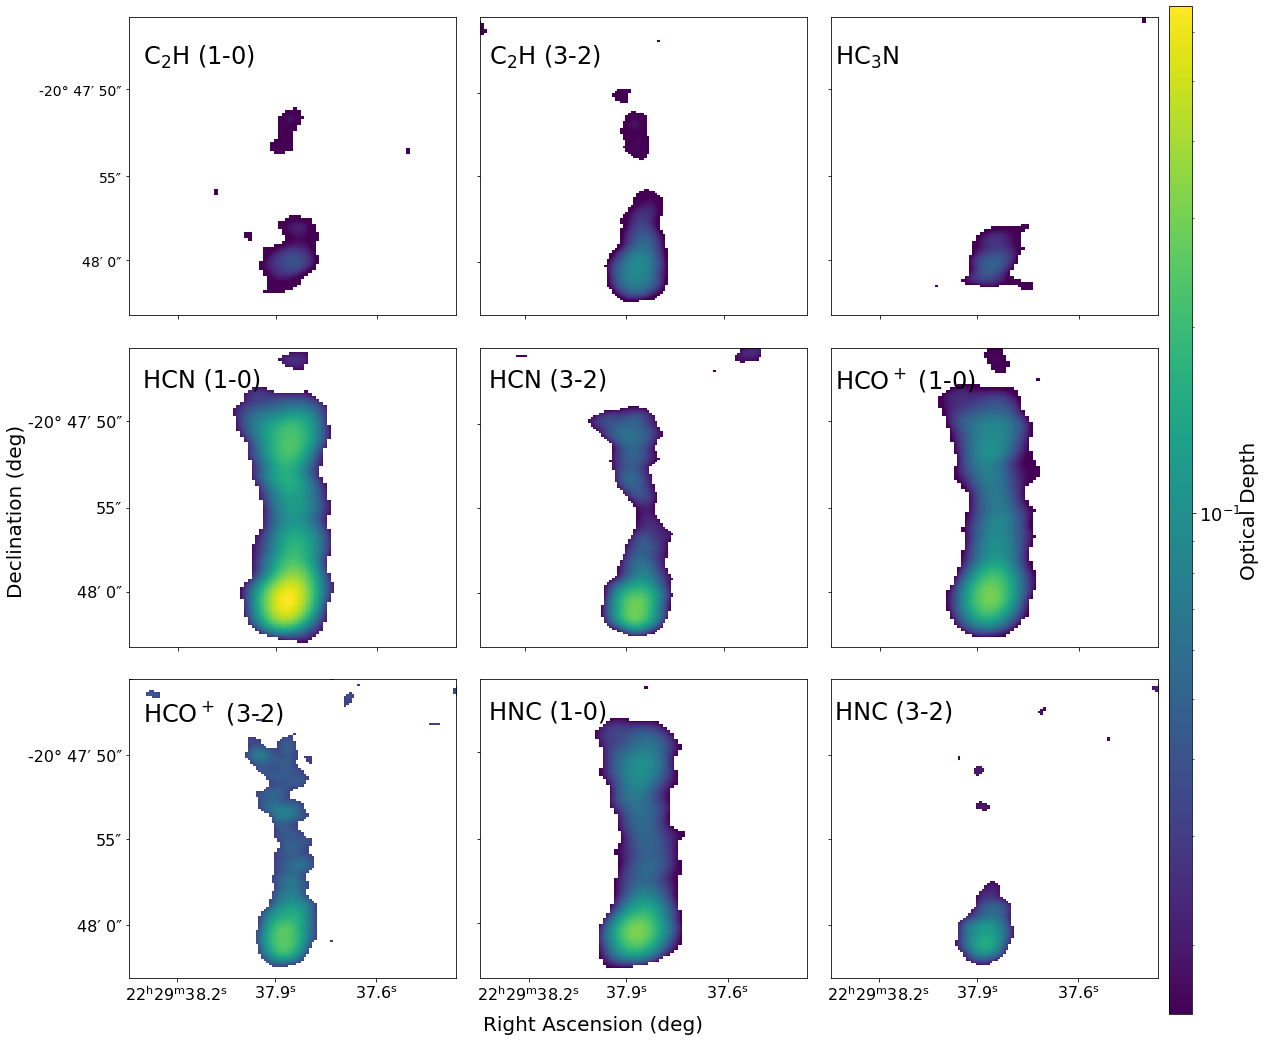

In [127]:
figure = plt.figure(figsize = [16, 14])

def opt_depth_map_c(globule ='GlobC', source = '12CO'):
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    data1 = data[0,:,:,:]
    h = 6.62608e-34
    k = 1.38065e-23

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)

    freq_start_ghz = header["CRVAL3"]/1e9
    freq_inc_ghz = header["CDELT3"]/1e9
    frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
    frequency_ghz = np.array(frequency_ghz, dtype = float)

    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    #print(vel_inc)

    if globule == 'GlobB':
        #figure = plt.figure(figsize=[27, 8])
        x1 = round(header["CRPIX1"]-(ra_start-337.4325)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(20.818+dec_start)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(20.81354+dec_start)/dec_inc)-2
    else:
        #figure = plt.figure(figsize=[24, 8])
        x1 = round(header["CRPIX1"]-(ra_start-337.40975)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.40565)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.80087)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1

    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    hnu_k = h*frequency[0]/k

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)

    if source == '12CO':
        d = 0.12
    elif source == '13CO':
        d = 0.1
    elif source == 'C18O':
        d = 0.15
    elif source == 'CCH':
        d = 0.15
    elif source == 'CCH_32':
        d = 0.08
    elif source == 'HC3N':
        d = 0.25
    elif source == 'HCN':
        d = 0.08
    elif source == 'HCN_32':
        d = 0.04
    elif source == 'HCOp':
        d = 0.1
    elif source == 'HCOp_32':
        d = 0.08
    elif source == 'HNC':
        d = 0.08
    elif source == 'HNC_32':
        d = 0.12

    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d*max_val:
            array.append(a[i])
    extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

    moment0 = np.sum(data3[array, :, :], axis = 0)*abs(vel_inc)
    sigma_mask = sigma_clip(moment0, sigma=2.8, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    mom0 = np.ma.array(moment0, mask = newmask)
    bmaj = header['BMAJ']#major beam width
    bmin = header['BMIN']#minor beam width
    I = np.nanmax(mom0)    
    t_mb = 1.222e3*mom0*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    Tex = 24.96 #Globule C
    #Tex = 23.94604986 #Globule B
    den = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb/hnu_k
    almost = 1-den
    opt_depth_map = -np.log(almost) 
    
    return opt_depth_map     
    
plt.subplot(331)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'CCH'), origin='lower', cmap=cm1, extent = [ra(source = 'CCH')[256],
                                                                                                   ra(source = 'CCH')[343],
                                                                                                   dec(source = 'CCH')[270],
                                                                                                   dec(source = 'CCH')[373]], 
           aspect = 'auto', norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                              vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))
ax1 = figure.add_subplot(3, 3, 1)

dec_val4 = np.abs(dec(source = 'CCH') + 20.7972222).argmin()
dec_val3 = np.abs(dec(source = 'CCH') + 20.7986111).argmin()
dec_val2 = np.abs(dec(source = 'CCH') + 20.8000000).argmin()
#dec_val1 = np.abs(dec(source = 'CCH') + 20.8180556).argmin()
ax1.set_yticks([dec(source = 'CCH')[dec_val2], dec(source = 'CCH')[dec_val3], dec(source = 'CCH')[dec_val4]])
ax1.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 14)

ra_val1 = np.abs(ra(source = 'CCH') - 337.4091667 ).argmin()
ra_val2 = np.abs(ra(source = 'CCH') - 337.4079167).argmin()
ra_val3 = np.abs(ra(source = 'CCH') - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax1.set_xticks([ra(source = 'CCH')[ra_val1], ra(source = 'CCH')[ra_val2], ra(source = 'CCH')[ra_val3]])
ax1.set_xticklabels([' ', ' ', ' '], fontsize = 14)

cbaxes1 = figure.add_axes([1.0, 0.0, 0.02, 1], zorder = 4) 
cbar1 = plt.colorbar(cax=cbaxes1, orientation='vertical')

for t in cbar1.ax.get_yticklabels():
    t.set_fontsize(18)

plt.subplot(332)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'CCH_32'), origin='lower', cmap=cm1, extent = [ra(source = 'CCH_32')[88],
                                                                                                   ra(source = 'CCH_32')[211],
                                                                                                   dec(source = 'CCH_32')[108],
                                                                                                   dec(source = 'CCH_32')[254]], 
           aspect = 'auto', norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                              vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax2 = figure.add_subplot(3, 3, 2)

dec_val4 = np.abs(dec(source = 'CCH_32') + 20.7972222).argmin()
dec_val3 = np.abs(dec(source = 'CCH_32') + 20.7986111).argmin()
dec_val2 = np.abs(dec(source = 'CCH_32') + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax2.set_yticks([dec(source = 'CCH_32')[dec_val2], dec(source = 'CCH_32')[dec_val3], dec(source = 'CCH_32')[dec_val4]])
ax2.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra(source = 'CCH_32') - 337.4091667 ).argmin()
ra_val2 = np.abs(ra(source = 'CCH_32') - 337.4079167).argmin()
ra_val3 = np.abs(ra(source = 'CCH_32') - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax2.set_xticks([ra(source = 'CCH_32')[ra_val1], ra(source = 'CCH_32')[ra_val2], ra(source = 'CCH_32')[ra_val3]])
ax2.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(333)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HC3N'), origin='lower', cmap=cm1, extent = [ra(source = 'HC3N')[256],
                                                                                                   ra(source = 'HC3N')[343],
                                                                                                   dec(source = 'HC3N')[270],
                                                                                                   dec(source = 'HC3N')[373]], 
           aspect = 'auto', norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                              vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax3 = figure.add_subplot(3, 3, 3)

dec_val4 = np.abs(dec(source = 'HC3N') + 20.7972222).argmin()
dec_val3 = np.abs(dec(source = 'HC3N') + 20.7986111).argmin()
dec_val2 = np.abs(dec(source = 'HC3N') + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax3.set_yticks([dec(source = 'HC3N')[dec_val2], dec(source = 'HC3N')[dec_val3], dec(source = 'HC3N')[dec_val4]])
ax3.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra(source = 'HC3N') - 337.4091667 ).argmin()
ra_val2 = np.abs(ra(source = 'HC3N') - 337.4079167).argmin()
ra_val3 = np.abs(ra(source = 'HC3N') - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax3.set_xticks([ra(source = 'HC3N')[ra_val1], ra(source = 'HC3N')[ra_val2], ra(source = 'HC3N')[ra_val3]])
ax3.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(334)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HCN'), origin='lower', cmap=cm1, extent = [ra(source = 'HCN')[256],
                                                                                                   ra(source = 'HCN')[343],
                                                                                                   dec(source = 'HCN')[270],
                                                                                                   dec(source = 'HCN')[373]], 
           aspect = 'auto', norm=mpl.colors.LogNorm())
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax4 = figure.add_subplot(3, 3, 4)

dec_val4 = np.abs(dec(source = 'HCN') + 20.7972222).argmin()
dec_val3 = np.abs(dec(source = 'HCN') + 20.7986111).argmin()
dec_val2 = np.abs(dec(source = 'HCN') + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax4.set_yticks([dec(source = 'HCN')[dec_val2], dec(source = 'HCN')[dec_val3], dec(source = 'HCN')[dec_val4]])
ax4.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 16)

ra_val1 = np.abs(ra(source = 'HCN') - 337.4091667 ).argmin()
ra_val2 = np.abs(ra(source = 'HCN') - 337.4079167).argmin()
ra_val3 = np.abs(ra(source = 'HCN') - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax4.set_xticks([ra(source = 'HCN')[ra_val1], ra(source = 'HCN')[ra_val2], ra(source = 'HCN')[ra_val3]])
ax4.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(335)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HCN_32'), origin='lower', cmap=cm1, extent = [ra(source = 'HCN_32')[88],
                                                                                                   ra(source = 'HCN_32')[211],
                                                                                                   dec(source = 'HCN_32')[108],
                                                                                                   dec(source = 'HCN_32')[254]], 
           aspect = 'auto', norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                              vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax5 = figure.add_subplot(3, 3, 5)

dec_val4 = np.abs(dec(source = 'HCN_32') + 20.7972222).argmin()
dec_val3 = np.abs(dec(source = 'HCN_32') + 20.7986111).argmin()
dec_val2 = np.abs(dec(source = 'HCN_32') + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax5.set_yticks([dec(source = 'HCN_32')[dec_val2], dec(source = 'HCN_32')[dec_val3], dec(source = 'HCN_32')[dec_val4]])
ax5.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra(source = 'HCN_32') - 337.4091667 ).argmin()
ra_val2 = np.abs(ra(source = 'HCN_32') - 337.4079167).argmin()
ra_val3 = np.abs(ra(source = 'HCN_32') - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax5.set_xticks([ra(source = 'HCN_32')[ra_val1], ra(source = 'HCN_32')[ra_val2], ra(source = 'HCN_32')[ra_val3]])
ax5.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(336)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HCOp'), origin='lower', cmap=cm1, extent = [ra(source = 'HCOp')[256],
                                                                                                   ra(source = 'HCOp')[343],
                                                                                                   dec(source = 'HCOp')[270],
                                                                                                   dec(source = 'HCOp')[373]], 
           aspect = 'auto', norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                              vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax6 = figure.add_subplot(3, 3, 6)

dec_val4 = np.abs(dec(source = 'HCOp') + 20.7972222).argmin()
dec_val3 = np.abs(dec(source = 'HCOp') + 20.7986111).argmin()
dec_val2 = np.abs(dec(source = 'HCOp') + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax6.set_yticks([dec(source = 'HCOp')[dec_val2], dec(source = 'HCOp')[dec_val3], dec(source = 'HCOp')[dec_val4]])
ax6.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra(source = 'HCOp') - 337.4091667 ).argmin()
ra_val2 = np.abs(ra(source = 'HCOp') - 337.4079167).argmin()
ra_val3 = np.abs(ra(source = 'HCOp') - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax6.set_xticks([ra(source = 'HCOp')[ra_val1], ra(source = 'HCOp')[ra_val2], ra(source = 'HCOp')[ra_val3]])
ax6.set_xticklabels([' ', ' ', ' '], fontsize = 16)

plt.subplot(3,3,7)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HCOp_32'), origin='lower', cmap=cm1, extent = [ra(source = 'HCOp_32')[88],
                                                                                                   ra(source = 'HCOp_32')[211],
                                                                                                   dec(source = 'HCOp_32')[108],
                                                                                                   dec(source = 'HCOp_32')[254]], 
           aspect = 'auto', norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                              vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax7 = figure.add_subplot(3, 3, 7)

dec_val4 = np.abs(dec(source = 'HCOp_32') + 20.7972222).argmin()
dec_val3 = np.abs(dec(source = 'HCOp_32') + 20.7986111).argmin()
dec_val2 = np.abs(dec(source = 'HCOp_32') + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax7.set_yticks([dec(source = 'HCOp_32')[dec_val2], dec(source = 'HCOp_32')[dec_val3], dec(source = 'HCOp_32')[dec_val4]])
ax7.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 16)

ra_val1 = np.abs(ra(source = 'HCOp_32') - 337.4091667 ).argmin()
ra_val2 = np.abs(ra(source = 'HCOp_32') - 337.4079167).argmin()
ra_val3 = np.abs(ra(source = 'HCOp_32') - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax7.set_xticks([ra(source = 'HCOp_32')[ra_val1], ra(source = 'HCOp_32')[ra_val2], ra(source = 'HCOp_32')[ra_val3]])
ax7.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 16)

plt.subplot(3,3,8)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HNC'), origin='lower', cmap=cm1, extent = [ra(source = 'HNC')[256],
                                                                                                   ra(source = 'HNC')[343],
                                                                                                   dec(source = 'HNC')[270],
                                                                                                   dec(source = 'HNC')[373]], 
           aspect = 'auto', norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                              vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax8 = figure.add_subplot(3, 3, 8)

dec_val4 = np.abs(dec(source = 'HNC') + 20.7972222).argmin()
dec_val3 = np.abs(dec(source = 'HNC') + 20.7986111).argmin()
dec_val2 = np.abs(dec(source = 'HNC') + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax8.set_yticks([dec(source = 'HNC')[dec_val2], dec(source = 'HNC')[dec_val3], dec(source = 'HNC')[dec_val4]])
ax8.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra(source = 'HNC') - 337.4091667 ).argmin()
ra_val2 = np.abs(ra(source = 'HNC') - 337.4079167).argmin()
ra_val3 = np.abs(ra(source = 'HNC') - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax8.set_xticks([ra(source = 'HNC')[ra_val1], ra(source = 'HNC')[ra_val2], ra(source = 'HNC')[ra_val3]])
ax8.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 16)

plt.subplot(3,3,9)
cm1 = plt.cm.get_cmap('viridis')
plt.imshow(opt_depth_map_c(globule = 'GlobC', source = 'HNC_32'), origin='lower', cmap=cm1, extent = [ra(source = 'HNC_32')[88],
                                                                                                   ra(source = 'HNC_32')[211],
                                                                                                   dec(source = 'HNC_32')[108],
                                                                                                   dec(source = 'HNC_32')[254]], 
           aspect = 'auto', norm=mpl.colors.LogNorm(vmin=np.nanmin(opt_depth_map_c(globule = 'GlobC', source = 'HCN')), 
                              vmax=np.nanmax(opt_depth_map_c(globule = 'GlobC', source = 'HCN'))))
#plt.clim(0, np.nanmax(opt_depth_map(globule = 'GlobB', source = '12CO')))
ax9 = figure.add_subplot(3, 3, 9)

dec_val4 = np.abs(dec(source = 'HNC_32') + 20.7972222).argmin()
dec_val3 = np.abs(dec(source = 'HNC_32') + 20.7986111).argmin()
dec_val2 = np.abs(dec(source = 'HNC_32') + 20.8000000).argmin()
#dec_val1 = np.abs(dec + 20.8180556).argmin()
ax9.set_yticks([dec(source = 'HNC_32')[dec_val2], dec(source = 'HNC_32')[dec_val3], dec(source = 'HNC_32')[dec_val4]])
ax9.set_yticklabels([' ',' ',' '], fontsize = 16)

ra_val1 = np.abs(ra(source = 'HNC_32') - 337.4091667 ).argmin()
ra_val2 = np.abs(ra(source = 'HNC_32') - 337.4079167).argmin()
ra_val3 = np.abs(ra(source = 'HNC_32') - 337.4066667).argmin()
#ra_val4 = np.abs(ra - 337.4287500).argmin()
ax9.set_xticks([ra(source = 'HNC_32')[ra_val1], ra(source = 'HNC_32')[ra_val2], ra(source = 'HNC_32')[ra_val3]])
ax9.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 16)

figure.text(0.5, -0.01, 'Right Ascension (deg)', fontsize=20, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal')
figure.text(0.0, 0.5, 'Declination (deg)', fontsize=20, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
figure.text(1.07, 0.5, 'Optical Depth', fontsize=20, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')

figure.text(0.11, 0.95, 'C$_2$H (1-0)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.41, 0.95, 'C$_2$H (3-2)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.71, 0.95, 'HC$_3$N', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.11, 0.63, 'HCN (1-0)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.41, 0.63, 'HCN (3-2)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.71, 0.63, 'HCO$^+$ (1-0)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.11, 0.3, 'HCO$^+$ (3-2)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.41, 0.3, 'HNC (1-0)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')
figure.text(0.71, 0.3, 'HNC (3-2)', fontsize=24, horizontalalignment='left', verticalalignment='center', rotation = 'horizontal')

plt.tight_layout()
plt.savefig(globule + '_' + 'Optical_Depth_Final.png', bbox_inches='tight')

# Column Density Maps

In [3]:
def column_density_map(globule = 'GlobC', source = '12CO'):
    
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    data1 = data[0,:,:,:]
    h = 6.62608e-34
    k = 1.38065e-23
    c = 299792458
    pi = math.pi
    figure = plt.figure(figsize=[10,10]) #Globule B
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)
    
    freq_start_ghz = header["CRVAL3"]/1e9
    freq_inc_ghz = header["CDELT3"]/1e9
    frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
    frequency_ghz = np.array(frequency_ghz, dtype = float)
    
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    
    if globule == 'GlobB':
        x1 = round(header["CRPIX1"]-(ra_start-337.434)/ra_inc)-1 
        x2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1 
        y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(dec_start+20.812)/dec_inc)-2
        Tex = 23.94604986
    elif globule == 'GlobC':
        x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1 
        x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1 
        y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1
        #print(x1, x2, y1, y2)
        Tex = 24.96
    
    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    if source == '12CO':
        B0 = 5.76e10
        A_lu = 7.16e-7
        r = 5
        b = 5
        if globule == 'GlobB':
            d = 0.25
        elif globule == 'GlobC':
            d = 0.12
    elif source == '13CO':
        B0 = 5.51e10
        A_lu = 6.25e-7
        r = 5
        b = 5
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.1
    elif source == 'C18O':
        B0 = 5.49e10
        A_lu = 6.18e-7
        r = 5
        b = 5
        if globule == 'GlobB':
            d = 0.28
        else:
            d = 0.15
    elif source == 'CCH':
        B0 = 4.37e10
        A_lu = 1.65e-6
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.15
    elif source == 'CCH_32':
        B0 = 4.37e10
        A_lu = 5.74e-5
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.15
        else:
            d = 0.08
    elif source == 'HC3N':
        B0 = 4.55e9
        A_lu = 1.01e-4
        r = 25
        b = 156
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.25
    elif source == 'HCN':
        B0 = 4.43e10
        A_lu = 2.40e-5
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.06
        else:
            d = 0.08
    elif source == 'HCN_32':
        B0 = 4.43e10
        A_lu = 8.33e-4
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.065
        else:
            d = 0.04
    elif source == 'HCOp':
        B0 = 4.46e10
        A_lu = 3.00e-5
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.08
        else:
            d = 0.1
    elif source == 'HCOp_32':
        B0 = 4.46e10
        A_lu = 1.04e-3
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.1
        else:
            d = 0.08
    elif source == 'HNC':
        B0 = 4.53e10
        A_lu = 2.69e-5
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.08
    elif source == 'HNC_32':
        B0 = 4.53e10
        A_lu = 9.34e-4
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.2
        else:
            d = 0.12

    hnu_k = h*frequency[0]/k
    #print(hnu_k)

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)

    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d*max_val:
            array.append(a[i])

    print(array)
    opt_data = data3[array, :, :]

    moment0 = np.nansum(data3[array, :, :], axis = 0)*abs(vel_inc)

    sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    mom0 = np.ma.array(moment0, mask = newmask)

    extent=[ra[x1],ra[x2],dec[y1],dec[y2]]
    
    ax = figure.add_subplot(1, 1, 1)
    bmaj = header['BMAJ']#major beam width
    bmin = header['BMIN'] #minor beam width
    bpa = header['BPA']
    beam = Ellipse(xy=(ra[x1 + 10], dec[y1 + 10]), width=bmaj, height=bmin, angle=bpa, color = 'green', zorder = 1)
    ax.add_artist(beam)

    I = np.nanmax(mom0)    
    t_mb = 1.222e3*mom0*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb/hnu_k
    almost = 1-den
    #print(almost)
    opt_depth_map = -np.log(almost)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u = Y*term1*opt_depth_map
    col_dens = N_u*Z/r*np.exp(h*B0*b/(k*Tex))
    #print(col_dens)

    plt.imshow(col_dens, origin= 'lower', extent=extent, zorder = 0)

    plt.xticks()
    plt.yticks()
    #plt.ylim(-20.801, -20.796)
    plt.xlabel('RA (deg)',fontsize=14)
    plt.ylabel('DEC (deg)',fontsize=14)
    plt.colorbar(label = 'Column Density ($\mathrm{cm^{-2}}$)', fraction=0.04, pad=0.04)
    #plt.clim(0, np.nanmax(col_dens)) #Globule B
    plt.title(source + ' Column Density', fontsize= 20)

    plt.savefig(globule + '_' + source + ' Column Density.png')

[10, 11, 25, 26, 35, 36]
Average:
4731798300000.0
1712


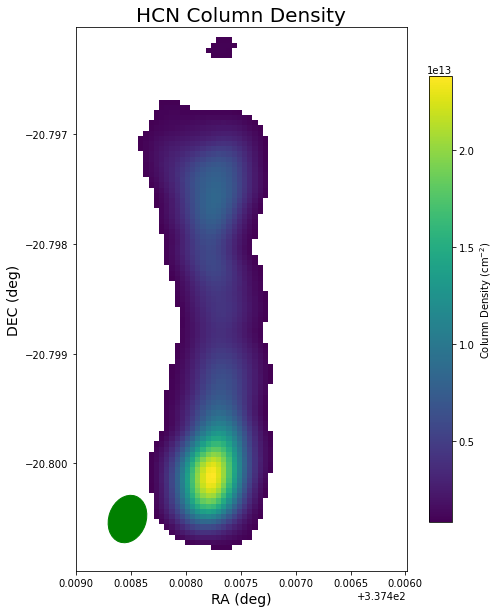

In [5]:
column_density_map(globule = 'GlobC', source = 'HCN')

In [16]:
def avg_column_density(globule = 'GlobB', source = '12CO'):
    
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    data1 = data[0,:,:,:]
    h = 6.62608e-34
    k = 1.38065e-23
    c = 299792458
    pi = math.pi
    figure = plt.figure(figsize=[10,10]) #Globule B
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * channels)
    frequency = np.array(frequency, dtype = float)
    
    freq_start_ghz = header["CRVAL3"]/1e9
    freq_inc_ghz = header["CDELT3"]/1e9
    frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
    frequency_ghz = np.array(frequency_ghz, dtype = float)
    
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    
    if globule == 'GlobB':
        x_1 = round(header["CRPIX1"]-(ra_start-337.433)/ra_inc)-1 
        x_2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1
        x1 = round(header["CRPIX1"]-(ra_start-337.4289)/ra_inc)-1 
        x2 = round(header["CRPIX1"]-(ra_start-337.4297)/ra_inc)-1 
        x3 = round(header["CRPIX1"]-(ra_start-337.4300)/ra_inc)-1
        x4 = round(header["CRPIX1"]-(ra_start-337.4308)/ra_inc)-1
        x5 = round(header["CRPIX2"]-(ra_start-337.4301)/ra_inc)-1
        x6 = round(header["CRPIX2"]-(ra_start-337.4322)/ra_inc)-1
        
        y_1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2
        y_2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-2 
        y1 = round(header["CRPIX2"]-(dec_start+20.8169)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.8162)/dec_inc)-1
        y3 = round(header["CRPIX2"]-(dec_start+20.8152)/dec_inc)-1
        y4 = round(header["CRPIX2"]-(dec_start+20.8149)/dec_inc)-1
        y5 = round(header["CRPIX2"]-(dec_start+20.8123)/dec_inc)-1
        y6 = round(header["CRPIX2"]-(dec_start+20.8130)/dec_inc)-1
        Tex = 23.94604986
    elif globule == 'GlobC':
        x_1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1 
        x_2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1 
        x1 = round(header["CRPIX1"]-(ra_start-337.4078)/ra_inc)-1 
        x2 = round(header["CRPIX1"]-(ra_start-337.4078)/ra_inc)-1
        x3 = round(header["CRPIX1"]-(ra_start-337.4076)/ra_inc)-1
        y_1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1
        y_2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.8001)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.7976)/dec_inc)-1
        y3 = round(header["CRPIX2"]-(dec_start+20.7971)/dec_inc)-1
        Tex = 24.96
    
    box = 6
    data2 = data1[:, :, np.arange(x_1, x_2)]
    data3 = data2[:, np.arange(y_1, y_2), :]
    
    data2_1 = data1[:, :, np.arange(x1-box, x1+box)]
    data3_1 = data2_1[:, np.arange(y1-box, y1+box), :]
    
    data2_2 = data1[:, :, np.arange(x2-box, x2+box)]
    data3_2 = data2_2[:, np.arange(y2-box, y2+box), :]
    
    data2_3 = data1[:, :, np.arange(x3-box, x3+box)]
    data3_3 = data2_3[:, np.arange(y3-box, y3+box), :]
    
    data2_4 = data1[:, :, np.arange(x4-box, x4+box)]
    data3_4 = data2_4[:, np.arange(y4-box, y4+box), :]
    
    data2_5 = data1[:, :, np.arange(x5-box, x5+box)]
    data3_5 = data2_5[:, np.arange(y5-box, y5+box), :]
    
    data2_6 = data1[:, :, np.arange(x6-box, x6+box)]
    data3_6 = data2_6[:, np.arange(y6-box, y6+box), :]


    if source == '12CO':
        B0 = 5.76e10
        A_lu = 7.16e-7
        r = 5
        b = 5
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.03
    elif source == '13CO':
        B0 = 5.51e10
        A_lu = 6.25e-7
        r = 5
        b = 5
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.1
    elif source == 'C18O':
        B0 = 5.49e10
        A_lu = 6.18e-7
        r = 5
        b = 5
        if globule == 'GlobB':
            d = 0.28
        else:
            d = 0.15
    elif source == 'CCH':
        B0 = 4.37e10
        A_lu = 1.65e-6
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.15
    elif source == 'CCH_32':
        B0 = 4.37e10
        A_lu = 5.74e-5
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.15
        else:
            d = 0.08
    elif source == 'HC3N':
        B0 = 4.55e9
        A_lu = 1.01e-4
        r = 25
        b = 156
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.25
    elif source == 'HCN':
        B0 = 4.43e10
        A_lu = 2.40e-5
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.06
        else:
            d = 0.08
    elif source == 'HCN_32':
        B0 = 4.43e10
        A_lu = 8.33e-4
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.065
        else:
            d = 0.04
    elif source == 'HCOp':
        B0 = 4.46e10
        A_lu = 3.00e-5
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.08
        else:
            d = 0.1
    elif source == 'HCOp_32':
        B0 = 4.46e10
        A_lu = 1.04e-3
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.1
        else:
            d = 0.08
    elif source == 'HNC':
        B0 = 4.53e10
        A_lu = 2.69e-5
        r = 2
        b = 2
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.08
    elif source == 'HNC_32':
        B0 = 4.53e10
        A_lu = 9.34e-4
        r = 7
        b = 12
        if globule == 'GlobB':
            d = 0.2
        else:
            d = 0.12

    hnu_k = h*frequency[0]/k
    #print(hnu_k)

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)
    print(max_val)
            
    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d*max_val:
            array.append(a[i])
    print(array)

    moment0_1 = np.sum(data3_1[array, :, :], axis = 0)*abs(vel_inc)
    moment0_2 = np.sum(data3_2[array, :, :], axis = 0)*abs(vel_inc)
    moment0_3 = np.sum(data3_3[array, :, :], axis = 0)*abs(vel_inc)
    moment0_4 = np.sum(data3_4[array, :, :], axis = 0)*abs(vel_inc)
    moment0_5 = np.sum(data3_5[array, :, :], axis = 0)*abs(vel_inc)
    moment0_6 = np.sum(data3_6[array, :, :], axis = 0)*abs(vel_inc)

    I_1 = np.nanmax(moment0_1)    
    t_mb_1 = 1.222e3*moment0_1*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_1 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_1/hnu_k
    almost_1 = 1-den_1
    opt_depth_map_1 = -np.log(almost_1)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_1 = Y*term1*opt_depth_map_1
    col_dens_1 = N_u_1*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_2 = np.nanmax(moment0_2)    
    t_mb_2 = 1.222e3*moment0_2*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_2 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_2/hnu_k
    almost_2 = 1-den_2
    opt_depth_map_2 = -np.log(almost_2)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_2 = Y*term1*opt_depth_map_2
    col_dens_2 = N_u_2*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_3 = np.nanmax(moment0_3)    
    t_mb_3 = 1.222e3*moment0_3*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_3 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_3/hnu_k
    almost_3 = 1-den_3
    opt_depth_map_3 = -np.log(almost_3)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_3 = Y*term1*opt_depth_map_3
    col_dens_3 = N_u_3*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_4 = np.nanmax(moment0_4)    
    t_mb_4 = 1.222e3*moment0_4*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_4 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_4/hnu_k
    almost_4 = 1-den_4
    opt_depth_map_4 = -np.log(almost_4)

    Z = (k*Tex)/(h*B0)+(1/3)
    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_4 = Y*term1*opt_depth_map_4
    col_dens_4 = N_u_4*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_5 = np.nanmax(moment0_5)    
    t_mb_5 = 1.222e3*moment0_5*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_5 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_5/hnu_k
    almost_5 = 1-den_5
    opt_depth_map_5 = -np.log(almost_5)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_5 = Y*term1*opt_depth_map_5
    col_dens_5 = N_u_5*Z/r*np.exp(h*B0*b/(k*Tex))
    
    I_6 = np.nanmax(moment0_6)    
    t_mb_6 = 1.222e3*moment0_6*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    X = 1/(np.exp(hnu_k/2.73)-1)
    den_6 = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb_6/hnu_k
    almost_6 = 1-den_6
    opt_depth_map_6 = -np.log(almost_6)

    Z = (k*Tex)/(h*B0)+(1/3)

    mu_lu = np.sqrt((A_lu*3*h*(c**3))/(64*(pi**4)*(frequency[0]**3)))
    term1 = 3*h/(8*pi**3*mu_lu**2)
    Y = np.exp(hnu_k/Tex)-1
    N_u_6 = Y*term1*opt_depth_map_6
    col_dens_6 = N_u_6*Z/r*np.exp(h*B0*b/(k*Tex))

    print('Average:')
    print(np.nanmean(col_dens_1))
    print(np.nanmean(col_dens_2))
    print(np.nanmean(col_dens_3))
    print(np.nanmean(col_dens_4))
    print(np.nanmean(col_dens_5))
    print(np.nanmean(col_dens_6))

In [17]:
avg_column_density(globule = 'GlobC', source = 'HNC_32')

UnboundLocalError: local variable 'x4' referenced before assignment

<Figure size 720x720 with 0 Axes>

# Individual Channel Optical Depth Maps

In [18]:
source = 'GlobB_HNC_32'
path = source + '.image.pbcor.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header
    
data1 = data[0,:,:,:]
h = 6.62608e-34
k = 1.38065e-23
    
ra_start = header["CRVAL1"]
ra_inc = header["CDELT1"]

channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

ra = ra_start + (ra_inc * channels)
ra = np.array(ra, dtype = float)

dec_start = header["CRVAL2"]
dec_inc = header["CDELT2"]

channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

dec = dec_start + (dec_inc * channels1)
dec = np.array(dec, dtype = float)
    
freq_start = header["CRVAL3"]
freq_inc = header["CDELT3"]

channels = np.arange(header["NAXIS3"])

frequency = freq_start + (freq_inc * channels)
frequency = np.array(frequency, dtype = float)
    
freq_start_ghz = header["CRVAL3"]/1e9
freq_inc_ghz = header["CDELT3"]/1e9
frequency_ghz = freq_start_ghz + (freq_inc_ghz * channels)
frequency_ghz = np.array(frequency_ghz, dtype = float)
    
velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
#print(vel_inc)
    
x1 = round(header["CRPIX1"]-(ra_start-337.433)/ra_inc)-1 #Globule B
#x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1 #Globule C
#print(x1)
x2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1 #Globule B
#x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1 #Globule C
#print(x2)
y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2 #Globule B
#y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1 #Globule C
#print(y1)
y2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-2 #Globule B
#y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1 #Globule C
#print(y2)
    
data2 = data1[:, :, np.arange(x1, x2)]
data3 = data2[:, np.arange(y1, y2), :]
    
hnu_k = h*frequency[0]/k
#print(hnu_k)
    
integrated = np.sum(data3[:, :, :], axis = 0)
 
max_val = np.nanmax(integrated)
print(max_val)
    
a = [x for x in range(len(data1[:, 0, 0]))]
array = []
for i in range(len(a)):
    if np.nanmax(data3[a[i], :, :]) > 0.16*max_val:
        array.append(a[i])
print(array)
    
extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

plt.show()
if len(array) < 4:
    nrows = 1
    ncols = len(array)
elif 4 <= len(array)<9:
    nrows = 2
    ncols = round(len(array)/2)
else:
    nrows = 3
    ncols = round(len(array)/3)

# Creates MxN Grid for Tot CHANNELS
def setup_axes(fig):
    g = axes_grid.ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), ngrids=None, direction='row', axes_pad=0.01, add_all=True, share_all=True, aspect=True, label_mode='L', cbar_mode=None)
    ax = g[-1]
    #cax = inset_axes(ax,
                     #width="8%", # width = 10% of parent_bbox width
                     #height="100%", # height : 50%
                     #loc=3,
                     #bbox_to_anchor=(1.01, 0, 1, 1),
                     #bbox_transform=ax.transAxes,
                     #borderpad=0.)
    return g
    
#ax = figure.add_subplot(1, 1, 1)
#bmaj = header['BMAJ']#major beam width
#bmin = header['BMIN'] #minor beam width
#bpa = header['BPA']
#beam = Ellipse(xy=(ra[x1 + 20], dec[y1 + 20]), width=bmaj, height=bmin, angle=bpa, color = 'green', zorder = 1)
#ax.add_artist(beam)

0.53766644
[0, 14, 15, 16, 17, 18]


Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
No contour levels were found within the data range.
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
invalid value encountered in log
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
invalid value encountered in log
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less
This figure includes Axes that are not compatible

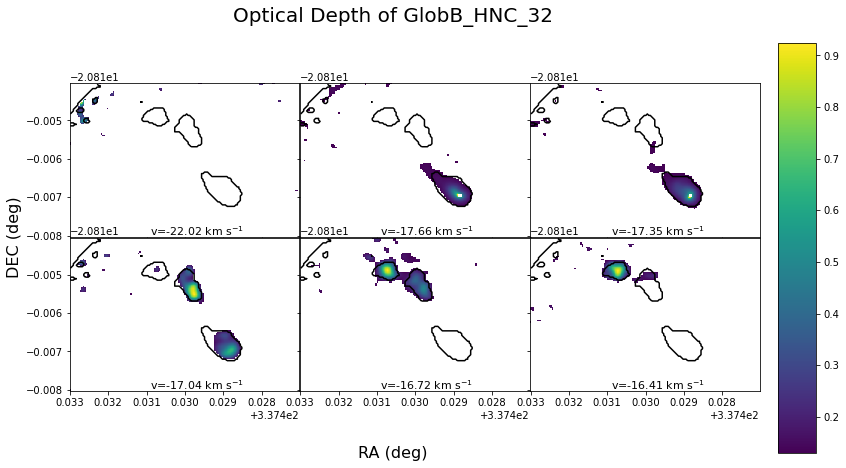

In [19]:
fig = plt.figure(1, figsize=(ncols*3.5, nrows*3))
g = setup_axes(fig)
moment0 = np.sum(data3[array, :, :], axis = 0)

extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

X = 1/(np.exp(hnu_k/2.73)-1)
#Tex = 28.92998995290211
Tex = 23.94604986

moment0 = np.sum(data3[array, :, :], axis = 0)
max_value = np.nanmax(moment0)
  
sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
newmask = (moment0 < np.amax(sigma_mask))
    
mom0 = np.ma.array(moment0, mask = newmask)

for i, ax in enumerate(g):
        ax.contour(newmask, levels = 0, colors='k', extent=extent, origin="lower")

for i, ax in enumerate(g):
    opt_data = data3[array[i],:,:]  
    t_mb = 1.222e3*opt_data*1000/(bmin*bmaj*3600*3600*frequency_ghz[0]**2)
    den = (1/(1/(np.exp(hnu_k/Tex)-1)-X))*t_mb/hnu_k
    almost = 1-den
    there = -np.log(almost)
    
    sigma_mask = sigma_clip(there, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (there < np.amax(sigma_mask))
    od_map = np.ma.array(there, mask = newmask)
    
    im = ax.imshow(od_map, origin= 'lower', extent=extent, zorder = 0)
    ax.text(0.35, 0.01, 'v=%2.2f km s$^{-1}$' %(velocity[array[i]]), transform=ax.transAxes, fontsize = 11, color = 'k')
    
fig.suptitle('Optical Depth of ' + source, fontsize=20, y=1.01, horizontalalignment='center', verticalalignment='center')
fig.text(0.5, 0, 'RA (deg)',fontsize=16, horizontalalignment='center', verticalalignment='center')
fig.text(0, 0.5, 'DEC (deg)',fontsize=16, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')

plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0, 0.05, 0.95])
fig.colorbar(im, cax=cbar_ax)
plt.show()